In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import PIL.Image

import tensorflow as tf
from tensorflow.keras.applications import VGG19

from tensorflow.keras.models import Model

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/neural-style-transfer/content3.jpeg
/kaggle/input/neural-style-transfer/content1.jpg
/kaggle/input/neural-style-transfer/content6.jpg
/kaggle/input/neural-style-transfer/style2.jpg
/kaggle/input/neural-style-transfer/style1.jpg
/kaggle/input/neural-style-transfer/style6.jpg
/kaggle/input/neural-style-transfer/content5.jpg
/kaggle/input/neural-style-transfer/style4.jpeg
/kaggle/input/neural-style-transfer/content7.jpg
/kaggle/input/neural-style-transfer/style5.jpg
/kaggle/input/neural-style-transfer/content4.jpg
/kaggle/input/neural-style-transfer/style7.jpg
/kaggle/input/neural-style-transfer/content2.jpg
/kaggle/input/neural-style-transfer/style3.jpg


In [2]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [3]:
max_dim = 512

def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)

In [4]:
style_path   = "/kaggle/input/neural-style-transfer/style2.jpg"
content_path = "/kaggle/input/neural-style-transfer/content2.jpg"

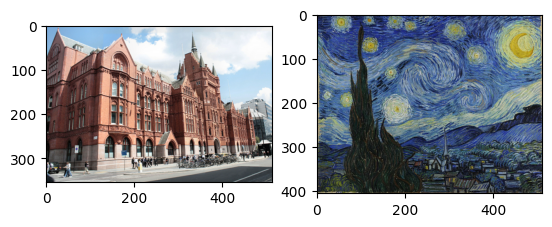

In [5]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Build The model

In [6]:
vgg = VGG19(include_top=False, weights='imagenet')

vgg.trainable = False

print()
for layer in vgg.layers:
  print(layer.name)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

input_layer
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [7]:
content_layers = ['block5_conv2',] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

all_layers =  style_layers + content_layers
print(all_layers)

['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1', 'block5_conv2']


In [8]:
outputs = [vgg.get_layer(name).output for name in all_layers]

# this model will extract the features
model = Model(inputs=vgg.input, outputs=outputs)

In [9]:
processed_content_image = preprocess_input(content_image)
processed_style_image = preprocess_input(style_image)

In [10]:
def extract_features(image, model):
    features = model(image)
    
    style_features = features[:len(style_layers)]
    
    content_feature = features[len(style_layers):][0]
    
    return style_features, content_feature

style_features, _ = extract_features(processed_style_image, model)
_, content_feature = extract_features(processed_content_image, model)


In [11]:
for name, output in zip(style_layers, style_features):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 405, 511, 64)
  min:  0.0
  max:  407.38733
  mean:  23.71835

block2_conv1
  shape:  (1, 202, 255, 128)
  min:  0.0
  max:  1300.2708
  mean:  100.46154

block3_conv1
  shape:  (1, 101, 127, 256)
  min:  0.0
  max:  4805.9805
  mean:  63.799885

block4_conv1
  shape:  (1, 50, 63, 512)
  min:  0.0
  max:  5561.9595
  mean:  296.83673

block5_conv1
  shape:  (1, 25, 31, 512)
  min:  0.0
  max:  1121.356
  mean:  10.551151



In [ ]:
# content, style, and variation weights (hyper-params)
content_weight = 1e3
style_weight = 1e-2
total_variation_weight = 1e-4

In [12]:
def content_style_loss(F, P):
    return tf.reduce_sum(tf.square(F - P)) / tf.cast(tf.size(F), tf.float32)

def gram_matrix(F):
    F = tf.reshape(F, [F.shape[-1], -1])
    return tf.linalg.matmul(F , tf.transpose(F))

def total_loss(content_loss, style_loss, generated_image):
    
    # Total variation loss (to encourage smoothness in the generated image)
    variation_loss = tf.image.total_variation(generated_image)
    
    # Combine the content, style, and variation losses
    total = content_weight * content_loss + style_weight * style_loss + total_variation_weight * tf.reduce_sum(variation_loss)
    return total
